<a href="https://colab.research.google.com/github/jamesholcombe/cell-instance-segmentation/blob/master/centroid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Vec2Instance 
### Centroid model training


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [3]:
def rle_decode(mask_rle, shape=(520, 704, 1), color=1):  # function to convert tabular mask data to image
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height, width, channels) of array to return 
    color: color for the mask
    Returns numpy array (mask)

    '''
    s = mask_rle.split()
    
    starts = list(map(lambda x: int(x) - 1, s[0::2]))
    lengths = list(map(int, s[1::2]))
    ends = [x + y for x, y in zip(starts, lengths)]
    
    img = np.zeros((shape[0] * shape[1], shape[2]), dtype=np.float32)
            
    for start, end in zip(starts, ends):
        img[start : end] = color
    
    return img.reshape(shape)  # Gives a new shape to an array without changing its data

In [5]:
#Loading libs 
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, GaussianNoise, Lambda, Dropout, UpSampling2D
from keras import backend as K
from keras.optimizer_v2 import adam
from keras.metrics import RootMeanSquaredError
from sklearn.model_selection import train_test_split
from pathlib import Path
from PIL import Image
from skimage import io


## Data Preperation


In [6]:
#Loading in the data 
DATAPATH = Path("/content/drive/MyDrive/DataSets/data")

#training meta data 
df_train = pd.read_csv(Path(DATAPATH / "train/.csv"))
df_train


x_train = np.stack([np.repeat(np.asarray(io.imread(DATAPATH / Path(f"train/{image_id}.png")))[:, :, np.newaxis], repeats=3, axis=2) for image_id in df_train["id"].unique()])


In [7]:
x_train.shape



(606, 520, 704, 3)

In [45]:

def create_centroids(annotations : pd.Series):
    
    mask = np.zeros((520, 704, 1))  # Return a new array of given shape and type, filled with zeros. Set the size and color scheme in one color
    for label in annotations:  # we go through all the data by masks (in the column "annotation")
        decoded = rle_decode(label, shape=(520, 704, 1))
        nonzero = decoded.nonzero()
        centroid = (round(nonzero[0].mean()), round(nonzero[1].mean())) # calculating centroid for each annotation
        mask[centroid] = 1
    return mask
        

def make_centroid(annotation : str):
      decoded = rle_decode(annotation, shape=(520, 704, 1))
      nonzero = decoded.nonzero()
      return (round(nonzero[0].mean()), round(nonzero[1].mean()))


def create_large_centroid(x,y):
    mask = np.zeros((520,704,1))
    mask[x-2:x+3,y-2:y+3] = 1 
    return mask


def make_mask(annotation : str ):
    x,y = make_centroid(annotation)
    return create_large_centroid(x,y)
    

def combine_centroids(annotations):
    return sum(annotations.apply(make_mask))





In [46]:
y_train = df_train.groupby("id")["annotation"].apply(combine_centroids)


In [47]:
y_train = np.stack(y_train)
y_train.shape

(606, 520, 704, 1)

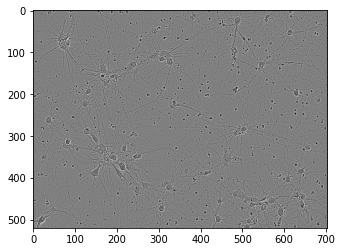

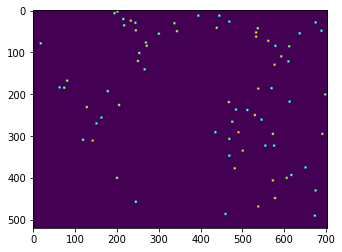

(1825, 704, 1)

In [48]:
'''plot sample of training data'''

rand_idx = np.random.randint(0,y_train.shape[0]) # generation random index to choose random sample

plt.imshow(x_train[rand_idx,:,:,:])
plt.show()

plt.imshow(y_train[rand_idx,:,:,0])
plt.show()


y_train[rand_idx].shape
sample = y_train[rand_idx]

np.nonzero(sample)[0]
sample[np.nonzero(sample)[0]].shape

### 2) Designing the Neural Network

It's a typical CNN with Convolutional layers, Max pooling operations and Dropouts.

In [12]:
x_in = Input(shape=(520, 704,3)) # input shape: (height, width, 3 bands of RGB)

x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = MaxPooling2D((2,2))(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions
x_temp = Dropout(0.25)(x_temp)
x_temp = Conv2D(32, (3, 3), dilation_rate=(2, 2), activation='relu', padding='same')(x_temp) # dilated convolutions

x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_out = Conv2D(1, (1, 1), activation='relu', padding='same')(x_temp)
x_out = UpSampling2D(8)(x_out)

# custom loss function to calculation weighted RMSE
def customLoss(yTrue, yPred):
    return K.sqrt(K.sum(K.flatten( K.tf.multiply(K.square(yTrue - yPred), yTrue+1)/(1*2+1) ))/(32*32))

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss=customLoss, optimizer=adam.Adam()) # setting loss and optimizer

model.summary() # printing the model summary

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 520, 704, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 520, 704, 32)      896       
                                                                 
 dropout (Dropout)           (None, 520, 704, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 520, 704, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 260, 352, 32)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 260, 352, 32)      9248      
                                                             

In [13]:
x ,y = x_train, y_train

In [14]:
'''training the model'''


x_train,  x_val,y_train, y_val = train_test_split(x,y,test_size=0.2)
batch_size = 8
epochs = 3

fit_h = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, shuffle=1, validation_data=(x_val,y_val))

Epoch 1/3
61/61 [==============================] - 811s 13s/step - loss: 2.4122 - val_loss: 0.7589
Epoch 2/3
61/61 [==============================] - 815s 13s/step - loss: 0.7812 - val_loss: 0.7589
Epoch 3/3
61/61 [==============================] - 836s 14s/step - loss: 0.7816 - val_loss: 0.7589


In [15]:
model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


In [16]:
y_scratch = y_train

TypeError: ignored

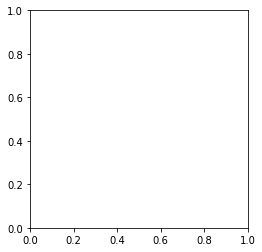